In [1]:
import sys
sys.path.append("../") 

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='../data',cache=True,as_frame=False)
X=X/255.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [4]:
import numpy as np
from hamiltonian import utils

num_examples,num_inputs=X_train.shape
num_outputs=len(np.unique(y_train))

#y_train=utils.one_hot(y_train,num_outputs)
#y_test=utils.one_hot(y_test,num_outputs)

In [5]:
y_train=np.int32(y_train)
y_test=np.int32(y_test)

In [6]:
#CADENA 1

In [7]:
import mxnet as mx
from mxnet import nd, autograd, gluon


model_ctx=mx.cpu()
par1={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}


In [8]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgld(model,par1,step_size=0.05,ctx=model_ctx)

In [9]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgld)

<module 'hamiltonian.inference.sgld' from '../hamiltonian/inference/sgld.py'>

In [10]:
par1,loss,posterior_samples=inference.fit(epochs=30,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

100%|██████████| 30/30 [07:55<00:00, 15.84s/it]


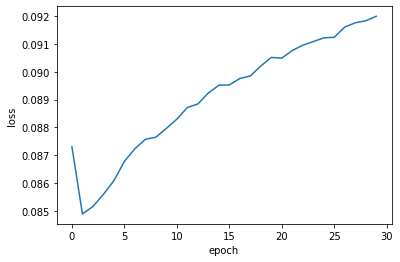

In [11]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [12]:
#CADENA 2

In [13]:
par2={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}

In [14]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgld(model,par2,step_size=0.05,ctx=model_ctx)

In [15]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgld)

<module 'hamiltonian.inference.sgld' from '../hamiltonian/inference/sgld.py'>

In [ ]:
par2,loss2,posterior_samples2=inference.fit(epochs=30,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

 90%|█████████ | 27/30 [07:14<00:46, 15.43s/it]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
y_pred=model.predict(par2,nd.array(X_test,ctx=model_ctx))

In [ ]:
from sklearn.metrics import classification_report

samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

In [18]:
# Posterior Diagnostics

In [19]:
import arviz as az

In [20]:
dataset1 = az.convert_to_inference_data(loss)
dataset1

Inference data with groups:
	> posterior

In [21]:
dataset2 = az.convert_to_inference_data(loss2)
dataset2

Inference data with groups:
	> posterior

In [22]:
dataset = az.concat(dataset1, dataset2, dim="chain")
dataset

Inference data with groups:
	> posterior

In [23]:
ess=az.ess(dataset)

In [24]:
ess

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 8.977

In [25]:
az.summary(dataset)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.269,0.012,0.255,0.287,0.004,0.003,9.0,22.0,1.41


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

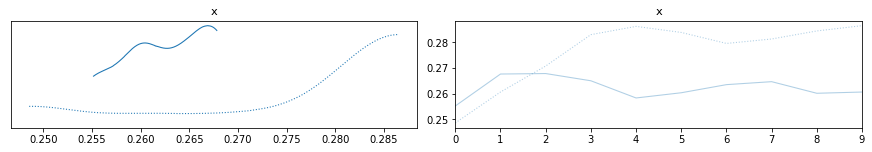

In [26]:
az.plot_trace(dataset)

array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

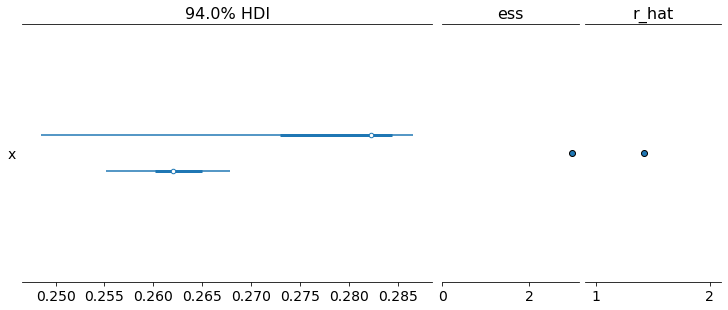

In [27]:
az.plot_forest(dataset, r_hat=True, ess= True)

In [87]:
az.waic(dataset)

TypeError: log likelihood not found in inference data object